### Results For paper

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
sys.path.append('..')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



from diabetes_onset_plotter import survival_fit_res, make_results

In [3]:
np.random.seed(seed = 0)

### Load Data

In [4]:
%%time
p = '../tempHybridSelectionMoreData/'
base_path = '../results/hier_matching_selection/'

treated = pd.read_pickle(p+'treated0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'match0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 211 ms, sys: 181 ms, total: 392 ms
Wall time: 771 ms


### Optional(filter registrations after  a particular month and before a particular month)

In [5]:
treated.MYR.min()

201710

In [6]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 202001
    month_filter_upper = 202101
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [7]:
filter_cols =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}
#put title in the figures 1 0 no
outcome_title = 0

kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [8]:

path_tabs = base_path+'tables/survival/'
path_figs = base_path+'figures/kaplan/'
path_figs2 = base_path+'figures/cox/' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [9]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB', 'T', 'E', 'Treatment']

summary_names = ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness', 'Treatment']

### Diabetes

In [10]:
%%time
after = 0
grace = 0 # if grace is setted after is setted 0 by default
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 13.6 s, sys: 82.9 ms, total: 13.7 s
Wall time: 13.7 s


In [11]:
survTr.head()

PERS_ID   T  E  ACUTE  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  ALLOW_AMT  \
0  2602482  24  0      0     0.0     0.0        0               81          0   
1  2603072  19  0      0     0.0     0.0        1               82        101   
2  2606370  10  0      0     0.0     0.0        1               82         23   
3  2608221   1  1      0     0.0     0.0        0               81        442   
4  2619378   1  1      0     0.0     0.0        1               78        399   

   ALLOW_ER  ...  IP_BIN  IP_BIN2  IP_BIN6  IP_C  LOB  MBR_GNDR  MEDICAID_LOB  \
0       0.0  ...       0      0.0      0.0     0    1         0    Commercial   
1       0.0  ...       0      0.0      0.0     0    1         0      Medicare   
2       0.0  ...       0      0.0      0.0     1    1         0      Medicare   
3       0.0  ...       0      0.0      0.0     0    1         0      Medicare   
4       0.0  ...       0      0.0      0.0     0    1         1      Medicare   

      MYR  PREGNANCY  Treatment  
0  201908        0.0          1  
1  202001        0.0          1  
2  202010        0.0          1  
3  202010        0.0          1  
4  201910        0.0          1  

[5 rows x 93 columns]

In [12]:
survTr.shape, survCo.shape

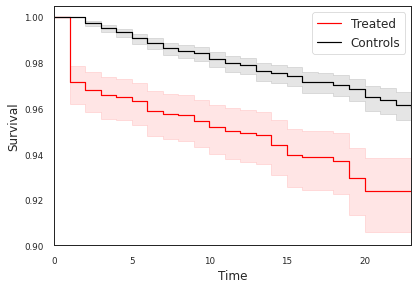

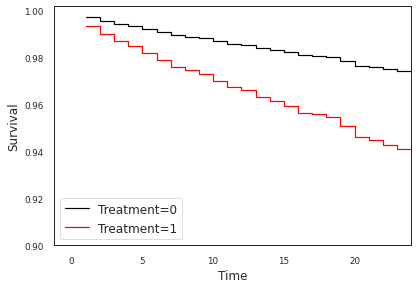

In [13]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
ylimDB = [0.9]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                     outcome_title = outcome_title, ylim = ylimDB)

In [14]:
lrsumm

test_statistic             p   -log2(p)
Diabetes       47.019839  7.027177e-12  37.050192

In [15]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                               1.299           0.378        3.440    0.001
Total Cost                        0.030           0.025        1.197    0.231
Gender                            0.091           0.143        0.634    0.526
Tobacco Use                       0.008           0.240        0.035    0.972
Pressure                        -13.310         841.001       -0.016    0.987
Obesity                           0.382           0.131        2.918    0.004
Hypertension                      0.132           0.141        0.934    0.350
Hypothyroid                      -0.066           0.205       -0.323    0.747
Disease Count                     1.536           0.600        2.557    0.011
Acute Care 2 Months               0.803           0.325        2.468    0.014
Acute Care 6 Months              -0.646           0.748       -0.864    0.388
Inpatient Visits 6 Months         0.306           0.622        0.492    0.623
Emergency Vistits 6 Months        0.387           0.686        0.564    0.573
Line of Bussiness                -0.187           0.258       -0.727    0.467
Treatment                         0.843           0.123        6.844    0.000

### ER

In [16]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [17]:
%%time
onset = 'ER-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace, onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])

survCo = data[1].groupby('PERS_ID').apply(survival_diabetes,after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 13.7 s, sys: 51.9 ms, total: 13.7 s
Wall time: 13.7 s


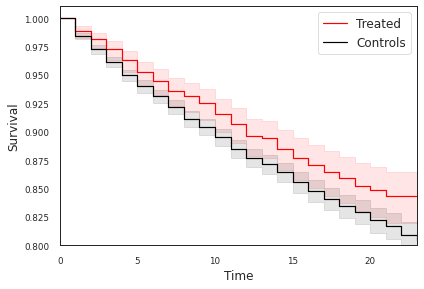

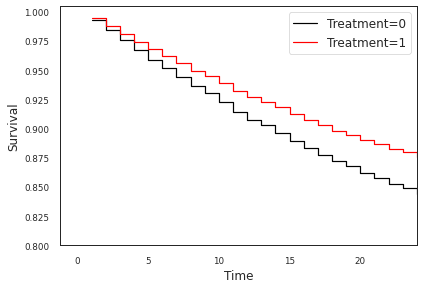

In [18]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Emergency Visits'
ylimER = [0.8]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, path_figs2=path_figs2, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylimER)

In [19]:
lrsumm

test_statistic         p  -log2(p)
Emergency Visits         6.00272  0.014284  6.129472

In [20]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                              -1.252           0.179       -6.985    0.000
Total Cost                        0.073           0.013        5.689    0.000
Gender                            0.013           0.075        0.180    0.857
Tobacco Use                       0.250           0.101        2.465    0.014
Pressure                         -0.368           0.713       -0.516    0.606
Obesity                           0.067           0.063        1.067    0.286
Hypertension                      0.180           0.072        2.519    0.012
Hypothyroid                      -0.287           0.117       -2.448    0.014
Disease Count                     0.746           0.305        2.446    0.014
Acute Care 2 Months               1.512           0.122       12.422    0.000
Acute Care 6 Months              -0.102           0.276       -0.371    0.711
Inpatient Visits 6 Months        -0.457           0.205       -2.230    0.026
Emergency Vistits 6 Months        0.557           0.257        2.172    0.030
Line of Bussiness                -0.330           0.108       -3.061    0.002
Treatment                        -0.244           0.078       -3.133    0.002

### IP

In [21]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [22]:
%%time
onset = 'IP-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes,after = after,  onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 13.6 s, sys: 43.6 ms, total: 13.7 s
Wall time: 13.7 s


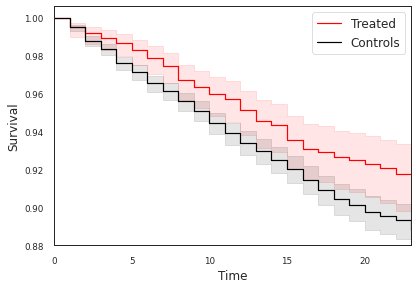

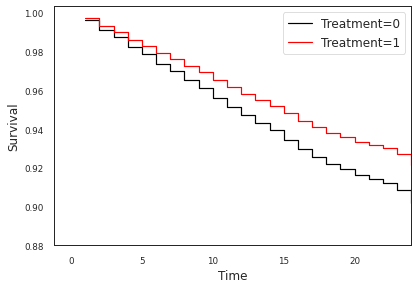

In [23]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Inpatient Visits'
ylimIP =  [0.88]

lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylimIP)

In [24]:
lrsumm

test_statistic        p  -log2(p)
Inpatient Visits         5.28664  0.02149  5.540214

In [25]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                              -1.222           0.244       -5.006    0.000
Total Cost                        0.099           0.018        5.480    0.000
Gender                            0.004           0.098        0.045    0.965
Tobacco Use                      -0.035           0.146       -0.240    0.811
Pressure                          0.487           0.588        0.829    0.407
Obesity                          -0.058           0.085       -0.680    0.497
Hypertension                      0.116           0.095        1.214    0.225
Hypothyroid                      -0.292           0.151       -1.939    0.052
Disease Count                     2.288           0.380        6.018    0.000
Acute Care 2 Months               0.944           0.167        5.654    0.000
Acute Care 6 Months              -0.901           0.263       -3.420    0.001
Inpatient Visits 6 Months         1.363           0.238        5.718    0.000
Emergency Vistits 6 Months        0.683           0.225        3.032    0.002
Line of Bussiness                -0.079           0.153       -0.519    0.604
Treatment                        -0.238           0.107       -2.225    0.026

### Acute Care IP OR ER

In [26]:
data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [27]:
%%time
onset = 'Acute-bin'

survTr = treated.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 13.6 s, sys: 32.1 ms, total: 13.7 s
Wall time: 13.7 s


In [28]:
survTr[survTr.E >0]

PERS_ID   T  E  ACUTE  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  \
4     2619378   3  1      0     0.0     0.0        1               78   
5     2621187  11  1      0     0.0     0.0        2               78   
6     2623521  28  1      0     0.0     0.0        0               77   
16    2649799   8  1      0     0.0     0.0        1               74   
17    2651688   4  1      0     0.0     0.0        0               74   
...       ...  .. ..    ...     ...     ...      ...              ...   
1550  5003629  15  1      0     0.0     0.0        0               27   
1557  5010677  16  1      0     0.0     0.0        0               39   
1562  5014675   3  1      0     0.0     0.0        1               26   
1575  5021778   1  1      1     1.0     1.0        1               24   
1586  5028397   2  1      0     0.0     0.0        0               39   

      ALLOW_AMT  ALLOW_ER  ...  IP_BIN  IP_BIN2  IP_BIN6  IP_C  LOB  MBR_GNDR  \
4           399       0.0  ...       0      0.0      0.0     0    1         1   
5         13007       0.0  ...       0      0.0      0.0     0    1         1   
6             0       0.0  ...       0      0.0      0.0     0    1         0   
16          333       0.0  ...       0      0.0      0.0     1    1         1   
17          179       0.0  ...       0      0.0      0.0     0    1         1   
...         ...       ...  ...     ...      ...      ...   ...  ...       ...   
1550          0       0.0  ...       0      0.0      0.0     0    1         0   
1557          0       0.0  ...       0      0.0      0.0     0    1         0   
1562        409       0.0  ...       0      0.0      0.0     0    1         0   
1575      20355    1161.0  ...       0      0.0      0.0     0    1         0   
1586          0       0.0  ...       0      0.0      0.0     0    1         0   

      MEDICAID_LOB     MYR  PREGNANCY  Treatment  
4         Medicare  201910        0.0          1  
5         Medicare  202001        0.0          1  
6         Medicare  201903        0.0          1  
16        Medicare  202011        0.0          1  
17        Medicare  202011        0.0          1  
...            ...     ...        ...        ...  
1550    Commercial  201912        0.0          1  
1557    Commercial  202001        0.0          1  
1562    Commercial  202010        0.0          1  
1575    Commercial  202007        0.0          1  
1586    Commercial  202005        0.0          1  

[258 rows x 94 columns]

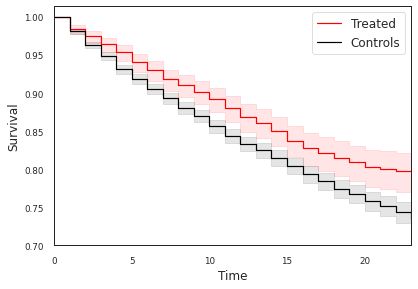

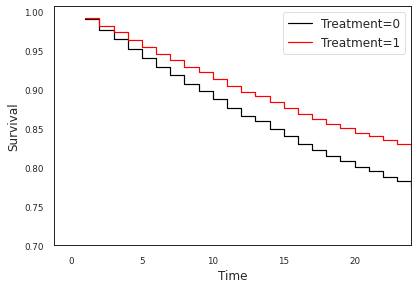

In [29]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care'
ylim = [0.7]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylim)

In [30]:
lrsumm

test_statistic         p   -log2(p)
Acute Care        11.52103  0.000688  10.505026

In [31]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                              -1.243           0.154       -8.063    0.000
Total Cost                        0.084           0.011        7.458    0.000
Gender                           -0.020           0.064       -0.314    0.753
Tobacco Use                       0.144           0.091        1.582    0.114
Pressure                          0.098           0.506        0.194    0.846
Obesity                           0.016           0.054        0.299    0.765
Hypertension                      0.139           0.061        2.271    0.023
Hypothyroid                      -0.263           0.099       -2.662    0.008
Disease Count                     1.126           0.263        4.276    0.000
Acute Care 2 Months               1.474           0.107       13.764    0.000
Acute Care 6 Months               0.466           0.229        2.031    0.042
Inpatient Visits 6 Months        -0.472           0.200       -2.356    0.018
Emergency Vistits 6 Months       -0.108           0.216       -0.499    0.618
Line of Bussiness                -0.300           0.095       -3.177    0.001
Treatment                        -0.276           0.068       -4.066    0.000

### Acute Care  diff and diff calculation

In [32]:
%%time
from utils import findDate, filter_first_date
from data_functions import make_date_to_MYR

pmpm = pd.read_pickle('../Pre_Matching_DATA/'+'pmpm.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

CPU times: user 11.3 s, sys: 12.6 s, total: 23.9 s
Wall time: 23.9 s


In [33]:
%%time
tr = treated.copy().drop(columns = ['Treatment'], axis = 1)
cr = controls.copy().drop(columns = ['Treatment'], axis = 1)

treated2 = (filter_first_date(findDate(tr.copy(), pmpm.copy(), 6))).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls2 = (filter_first_date(findDate(cr.copy(), pmpm.copy(), 6))).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

controls2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
treated2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
treated2['Treatment'] = 1
controls2['Treatment'] = 0
data2 = [treated2,  controls2]
for d in data2:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

CPU times: user 32.9 s, sys: 3.75 s, total: 36.7 s
Wall time: 36.6 s


In [34]:
treated2.shape, controls2.shape

In [35]:
treated.PERS_ID.unique().shape, controls.PERS_ID.unique().shape

In [36]:
treated2.PERS_ID.unique().shape, controls2.PERS_ID.unique().shape

In [37]:
%%time
times = [0]
onset = 'Acute-bin'


survTr = treated2.copy().groupby('PERS_ID').apply(survival_diabetes,  grace = times[0], onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls2.copy().groupby('PERS_ID').apply(survival_diabetes, grace = times[0], onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
# curves.append((survTr, survCo))

CPU times: user 12.3 s, sys: 78.6 ms, total: 12.3 s
Wall time: 12.3 s


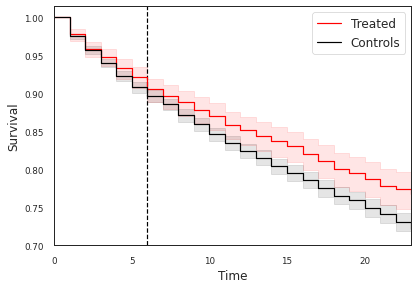

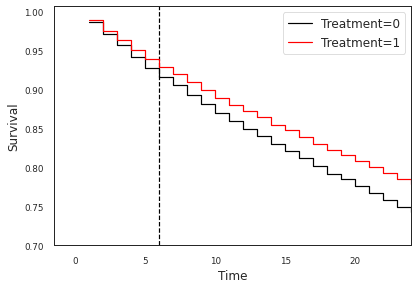

In [38]:
fittedDD, rmstAcuteDD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                      model = model, model_type = model_type,
                      model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                     log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care_dd'
ylim = [0.7]
lrsummDD, ax1, ax2, summDD = make_results(fittedDD, survTr, survCo, path_tabs = path_tabs, 
                                  path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                  model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                  filter_cols = filter_cols2, summary_names = summary_names,
                                 log_normalize = log_normalize, normalize = normalize,
                                 kaplan_plot_params=kaplan_plot_params,
                                  timeline = timeline,
                                  outcome_title = 0, ylim = ylim, ver_line = True, ver_line_val = 6)

In [39]:
lrsummDD

test_statistic         p  -log2(p)
Acute Care_dd       10.569956  0.001149  9.764898

In [40]:
summDD

Coefficient  Standard Error  z-statistic  p-value
Age                              -1.110           0.138       -8.025    0.000
Total Cost                        0.083           0.010        8.693    0.000
Gender                            0.043           0.059        0.736    0.462
Tobacco Use                       0.151           0.085        1.776    0.076
Pressure                         -0.010           0.507       -0.020    0.984
Obesity                          -0.158           0.051       -3.097    0.002
Hypertension                     -0.046           0.059       -0.786    0.432
Hypothyroid                      -0.213           0.088       -2.429    0.015
Disease Count                     1.402           0.244        5.738    0.000
Acute Care 2 Months               1.488           0.094       15.849    0.000
Acute Care 6 Months               0.642           0.232        2.773    0.006
Inpatient Visits 6 Months        -0.286           0.191       -1.495    0.135
Emergency Vistits 6 Months       -0.347           0.221       -1.568    0.117
Line of Bussiness                -0.490           0.083       -5.886    0.000
Treatment                        -0.175           0.062       -2.812    0.005

### Load all Log Rank Sums in a matrix

In [41]:
from pathlib import Path
pp = Path(path_tabs)

df2 = None
for i, ff in enumerate(pp.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)

df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['LogRank Statistic', 'LogRank Test P-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care', 'Acute Care DD']
for month, i in zip([6,12,18,24], [0,1,2,3]):
    df2['RMST Difference After '+ str(month)+' Months'] = np.array([rmstD[i], rmstER[i], rmstIP[i], rmstAcute[i], rmstAcuteDD[i]])
df2.to_csv(path_tabs+'all_logrank.csv')

In [42]:
df2.round(2)

LogRank Statistic  LogRank Test P-value  \
Diabetes                      47.02                  0.00   
Emergency Visits               6.00                  0.01   
Inpatient Vistis               5.29                  0.02   
Acute Care                    11.52                  0.00   
Acute Care DD                 10.57                  0.00   

                  RMST Difference After 6 Months  \
Diabetes                                   -0.14   
Emergency Visits                            0.05   
Inpatient Vistis                            0.03   
Acute Care                                  0.07   
Acute Care DD                               0.04   

                  RMST Difference After 12 Months  \
Diabetes                                    -0.32   
Emergency Visits                             0.16   
Inpatient Vistis                             0.11   
Acute Care                                   0.26   
Acute Care DD                                0.14   

                  RMST Difference After 18 Months  \
Diabetes                                    -0.51   
Emergency Visits                             0.29   
Inpatient Vistis                             0.22   
Acute Care                                   0.47   
Acute Care DD                                0.34   

                  RMST Difference After 24 Months  
Diabetes                                    -0.74  
Emergency Visits                             0.46  
Inpatient Vistis                             0.37  
Acute Care                                   0.76  
Acute Care DD                                0.57